In [1]:
# 在 EMA 之上，KD 超賣，低 RSI
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672535100000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 10:59:59  1196.01  1195.40  1196.74  1194.11  3752.0476
1     2023-01-01 11:59:59  1195.41  1194.04  1195.41  1191.71  7493.4207
2     2023-01-01 12:59:59  1194.05  1192.92  1194.05  1190.57  6409.2491
3     2023-01-01 13:59:59  1192.92  1194.54  1194.67  1192.71  2316.3448
4     2023-01-01 14:59:59  1194.55  1194.81  1195.23  1193.81  4102.0957
...                   ...      ...      ...      ...      ...        ...
2014  2023-03-26 09:59:59  1750.58  1751.70  1755.05  1747.94  8355.0758
2015  2023-03-26 10:59:59  1751.70  1752.59  1754.15  1750.34  5861.6813
2016  2023-03-26 11:59:59  1752.58  1749.57  1754.87  1747.48  7531.9002
2017  2023-03-26 12:59:59  1749.58  1749.12  1749.96  1746.00  4774.8073
2018  2023-03-26 13:59:59  1749.11  1746.76  1749.84  1746.50  2157.8986

[2019 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
# sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
# ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,slowk,slowd
0,2023-01-01 10:59:59,1196.01,1195.40,1196.74,1194.11,3752.0476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 11:59:59,1195.41,1194.04,1195.41,1191.71,7493.4207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 12:59:59,1194.05,1192.92,1194.05,1190.57,6409.2491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 13:59:59,1192.92,1194.54,1194.67,1192.71,2316.3448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 14:59:59,1194.55,1194.81,1195.23,1193.81,4102.0957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2023-03-26 09:59:59,1750.58,1751.70,1755.05,1747.94,8355.0758,1746.357667,1763.420792,1746.357667,1729.294542,52.059353,1749.993863,77.004388,69.731419
2015,2023-03-26 10:59:59,1751.70,1752.59,1754.15,1750.34,5861.6813,1746.490000,1763.682344,1746.490000,1729.297656,52.570308,1750.019695,78.779418,76.851483
2016,2023-03-26 11:59:59,1752.58,1749.57,1754.87,1747.48,7531.9002,1746.635333,1763.855630,1746.635333,1729.415037,50.599577,1750.015220,72.756282,76.180029
2017,2023-03-26 12:59:59,1749.58,1749.12,1749.96,1746.00,4774.8073,1746.830667,1764.026308,1746.830667,1729.635025,50.297012,1750.006313,71.858795,74.464832


In [9]:
def conditions(df):

    # c1 Close > ema 200
    # c2 k < 15
    # c3 rsi < 50 & > 30

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['Close'] <= df['ema']
        # c2
        df['c2'] = df['slowk'] <= 15
        # c3
        df['c3'] = (df['rsi'] < 50) & (df['rsi'] > 30)

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,slowk,slowd,c1,c2,c3,signal,openbuy
0,2023-01-01 10:59:59,1196.01,1195.40,1196.74,1194.11,3752.0476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 11:59:59,1195.41,1194.04,1195.41,1191.71,7493.4207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
2,2023-01-01 12:59:59,1194.05,1192.92,1194.05,1190.57,6409.2491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
3,2023-01-01 13:59:59,1192.92,1194.54,1194.67,1192.71,2316.3448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2023-01-01 14:59:59,1194.55,1194.81,1195.23,1193.81,4102.0957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2023-03-26 09:59:59,1750.58,1751.70,1755.05,1747.94,8355.0758,1746.357667,1763.420792,1746.357667,1729.294542,52.059353,1749.993863,77.004388,69.731419,False,False,False,False,False
2015,2023-03-26 10:59:59,1751.70,1752.59,1754.15,1750.34,5861.6813,1746.490000,1763.682344,1746.490000,1729.297656,52.570308,1750.019695,78.779418,76.851483,False,False,False,False,False
2016,2023-03-26 11:59:59,1752.58,1749.57,1754.87,1747.48,7531.9002,1746.635333,1763.855630,1746.635333,1729.415037,50.599577,1750.015220,72.756282,76.180029,True,False,False,False,False
2017,2023-03-26 12:59:59,1749.58,1749.12,1749.96,1746.00,4774.8073,1746.830667,1764.026308,1746.830667,1729.635025,50.297012,1750.006313,71.858795,74.464832,True,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():
    
    tp_rsi = 68
    tp_slowk = 80
    tp_slowd = 80

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif in_position == True and ((buydf.at[index, 'rsi'] >= tp_rsi) & (buydf.at[index, 'slowk'] >= tp_slowk) & (buydf.at[index, 'slowd'] >= tp_slowd)):
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low       Volume  \
623   2023-01-27 09:59:59  1588.87  1562.81  1591.90  1552.54   78008.9493   
624   2023-01-27 10:59:59  1562.81  1570.51  1572.70  1560.58   18146.0462   
658   2023-01-28 20:59:59  1586.19  1582.86  1586.19  1579.10   11737.9330   
659   2023-01-28 21:59:59  1582.87  1573.30  1582.87  1561.76   54484.0088   
660   2023-01-28 22:59:59  1573.30  1570.60  1574.00  1570.00   11071.4082   
666   2023-01-29 04:59:59  1577.12  1561.32  1577.59  1560.00   14034.3393   
667   2023-01-29 05:59:59  1561.31  1566.98  1569.64  1555.99   15558.2811   
689   2023-01-30 03:59:59  1629.37  1653.86  1660.00  1628.95   67990.7192   
703   2023-01-30 17:59:59  1619.92  1587.79  1620.43  1581.60   83690.3986   
704   2023-01-30 18:59:59  1587.80  1585.69  1595.56  1577.00   45959.5274   
705   2023-01-30 19:59:59  1585.69  1581.55  1588.88  1577.98   27263.0766   
713   2023-01-31 03:59:59  1578.20  1554.24  1578.39  1535.00   

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



             Close_Time     Open    Close     High      Low          sma  \
0   2023-01-27 10:59:59  1562.81  1570.51  1572.70  1560.58  1604.088333   
1   2023-01-28 21:59:59  1582.87  1573.30  1582.87  1561.76  1590.093333   
2   2023-01-28 22:59:59  1573.30  1570.60  1574.00  1570.00  1589.812000   
3   2023-01-29 05:59:59  1561.31  1566.98  1569.64  1555.99  1588.960333   
4   2023-01-30 03:59:59  1629.37  1653.86  1660.00  1628.95  1595.067667   
5   2023-01-30 18:59:59  1587.80  1585.69  1595.56  1577.00  1620.306667   
6   2023-01-30 19:59:59  1585.69  1581.55  1588.88  1577.98  1619.780667   
7   2023-01-31 03:59:59  1578.20  1554.24  1578.39  1535.00  1613.469333   
8   2023-02-09 11:59:59  1632.41  1619.05  1633.32  1608.80  1663.052000   
9   2023-02-09 12:59:59  1619.05  1623.85  1627.31  1610.22  1661.670000   
10  2023-02-13 06:59:59  1511.22  1513.36  1515.10  1493.08  1530.943333   
11  2023-02-13 09:59:59  1518.28  1507.03  1520.00  1501.59  1530.564000   
12  2023-02-

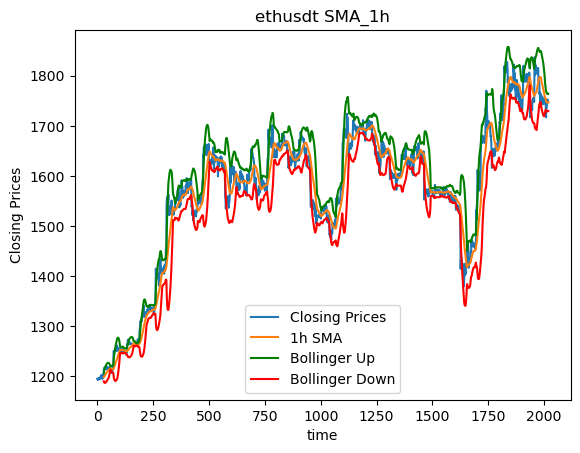

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()